### Imports

In [12]:
import asyncio
import nest_asyncio
from bleak import BleakScanner, BleakClient
from datetime import datetime
import matplotlib.pyplot as plt

# Intoduction

This notebook is not intended to be a detailed walkthrough/guide of this investigation; it is more so just a collection of snippets of code for feature references. 


Having never really played Bluetooth Low Energy (BLE) before, I wanted to explore this communication protocol by investigating how Oral-B toothbrushes interact with their app. Know that this communication happens over BLE. The aim of this introduction project is to understand how BLE works and build a python script to record the time of brushing sessions using the information from the toothbrush. 

# Getting an understanding
## Finding the Toothbrush

In [6]:
# This script scans for BLE devices for 10 seconds then prints findings
# Uses this script to identify the address of the toothbrush
# Make sure to have the toothbrush on during the scan

async def scan_BLE(time_seconds=10): # Change the number of seconds to scan for
    print(f"Scanning for {time_seconds} seconds make sure the toothbrush is on")
    devices = await BleakScanner.discover(timeout=time_seconds)
    return devices

async def main():
    devices = await scan_BLE()
    print("Found devices:")
    for device in devices:
        print(f"Name: {device.name}, Address: {device.address}, RSSI: {device.rssi}")

await main()

Scanning for 10 seconds make sure the toothbrush is on


Found devices:
Name: Oral-B Toothbrush, Address: 212B5F11-23E1-ED1E-6CE0-2F09CE4E619C, RSSI: -43


## Services and Characteristics Identification

In [11]:
# This script works to find out what services and characteristics are being sent by the toothbrush over BLE
# The device_address is the address of the toothbrush found in the scan script above
# This was used to help find out what services was related to the time

nest_asyncio.apply() # Needed as running asyncio in jupyter notebook

toothbrush_address = "212B5F11-23E1-ED1E-6CE0-2F09CE4E619C"  # As found in the scan script above

async def explore_services(address):
    async with BleakClient(address) as client:
        services = await client.get_services()
        for service in services:
            print(f"Service: {service.uuid}")
            for characteristic in service.characteristics:
                print(f"  Characteristic: {characteristic.uuid} - {characteristic.properties}")

asyncio.run(explore_services(toothbrush_address))

Service: a0f0fff0-5047-4d53-8208-4f72616c2d42
  Characteristic: a0f0fff1-5047-4d53-8208-4f72616c2d42 - ['read', 'write', 'notify']
  Characteristic: a0f0fff2-5047-4d53-8208-4f72616c2d42 - ['read', 'write']
  Characteristic: a0f0fff3-5047-4d53-8208-4f72616c2d42 - ['read', 'write']
  Characteristic: a0f0fff4-5047-4d53-8208-4f72616c2d42 - ['read', 'write']
Service: a0f0ff00-5047-4d53-8208-4f72616c2d42
  Characteristic: a0f0ff01-5047-4d53-8208-4f72616c2d42 - ['read']
  Characteristic: a0f0ff02-5047-4d53-8208-4f72616c2d42 - ['read']
  Characteristic: a0f0ff03-5047-4d53-8208-4f72616c2d42 - ['read', 'write']
  Characteristic: a0f0ff04-5047-4d53-8208-4f72616c2d42 - ['read', 'notify']
  Characteristic: a0f0ff05-5047-4d53-8208-4f72616c2d42 - ['read', 'notify']
  Characteristic: a0f0ff06-5047-4d53-8208-4f72616c2d42 - ['read', 'notify']
  Characteristic: a0f0ff07-5047-4d53-8208-4f72616c2d42 - ['read', 'notify']
  Characteristic: a0f0ff08-5047-4d53-8208-4f72616c2d42 - ['read', 'notify']
  Character

Listening for notifications... Press Ctrl+C to stop.
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 1280
Notification from a0f0ff09-5047-4d53-8208-4f72616c2d42: 266240
Notification from a0f0ff05-5047-4d53-8208-4f72616c2d42: 128009
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 1536
Notification from a0f0ff09-5047-4d53-8208-4f72616c2d42: 267264
Notification from a0f0ff05-5047-4d53-8208-4f72616c2d42: 128009
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 1792
Notification from a0f0ff09-5047-4d53-8208-4f72616c2d42: 268032
Notification from a0f0ff05-5047-4d53-8208-4f72616c2d42: 128009
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 2048
Notification from a0f0ff09-5047-4d53-8208-4f72616c2d42: 268800
Notification from a0f0ff05-5047-4d53-8208-4f72616c2d42: 128009
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 2304
Notification from a0f0ff09-5047-4d53-8208-4f72616c2d42: 269824
Notification from a0f0ff05-5047-4d53-8208-4f72616c2d42: 128009
Notification

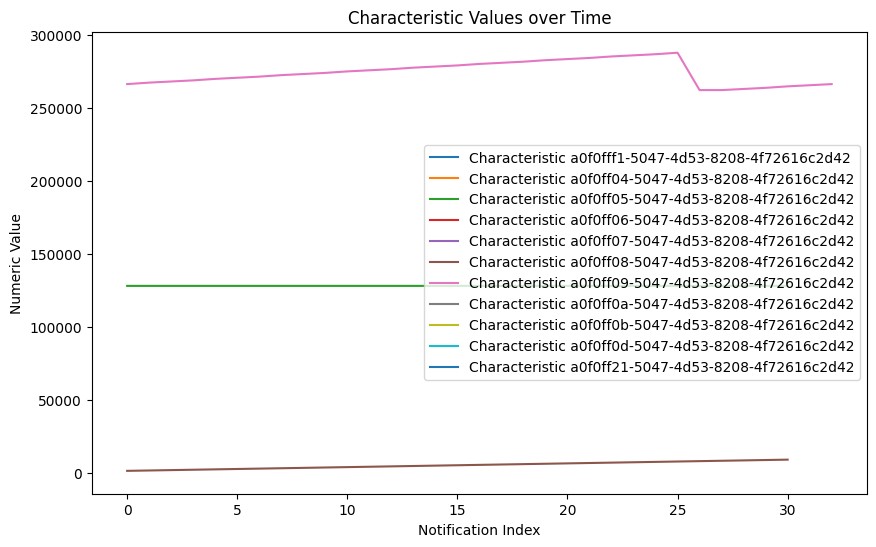

In [16]:
nest_asyncio.apply() # Needed as running asyncio in jupyter notebook

# All the characteristics that are notifying data from the toothbrush
notify_characteristics = [
    "a0f0fff1-5047-4d53-8208-4f72616c2d42",
    "a0f0ff04-5047-4d53-8208-4f72616c2d42",
    "a0f0ff05-5047-4d53-8208-4f72616c2d42",
    "a0f0ff06-5047-4d53-8208-4f72616c2d42",
    "a0f0ff07-5047-4d53-8208-4f72616c2d42",
    "a0f0ff08-5047-4d53-8208-4f72616c2d42",
    "a0f0ff09-5047-4d53-8208-4f72616c2d42",
    "a0f0ff0a-5047-4d53-8208-4f72616c2d42",
    "a0f0ff0b-5047-4d53-8208-4f72616c2d42",
    "a0f0ff0d-5047-4d53-8208-4f72616c2d42",
    "a0f0ff21-5047-4d53-8208-4f72616c2d42",
]

# Dictionary to store the notifications so can plot them later
notifications = {char: [] for char in notify_characteristics}

# Turns the data into a numeric value
def convert_to_numeric(data):
    return int.from_bytes(data, byteorder='little')

async def notification_handler(sender, data):
    char_uuid = sender.uuid
    numeric_value = convert_to_numeric(data) # Turning the byte data into a numeric value
    print(f"Notification from {char_uuid}: {numeric_value}") 
    notifications[char_uuid].append(numeric_value) # Storing the data for plotting

async def main(address):
    async with BleakClient(address) as client:
        for char_uuid in notify_characteristics:
            await client.start_notify(char_uuid, notification_handler)
        await asyncio.sleep(30)  # Run for 30 seconds
        for char_uuid in notify_characteristics:
            await client.stop_notify(char_uuid)

asyncio.run(main(toothbrush_address))

# Plotting the recorded data
plt.figure(figsize=(10, 6))
for char_uuid in notify_characteristics:
    plt.plot(notifications[char_uuid], label=f'Characteristic {char_uuid}')

plt.xlabel('Notification Index')
plt.ylabel('Numeric Value')
plt.title('Characteristic Values over Time')
plt.legend()
plt.show()

Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 1280
Notification from a0f0ff09-5047-4d53-8208-4f72616c2d42: 266240
Notification from a0f0ff05-5047-4d53-8208-4f72616c2d42: 111624
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 1536
Notification from a0f0ff09-5047-4d53-8208-4f72616c2d42: 267264
Notification from a0f0ff05-5047-4d53-8208-4f72616c2d42: 111624
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 1792
Notification from a0f0ff09-5047-4d53-8208-4f72616c2d42: 268032
Notification from a0f0ff05-5047-4d53-8208-4f72616c2d42: 111624
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 2048
Notification from a0f0ff09-5047-4d53-8208-4f72616c2d42: 268800
Notification from a0f0ff05-5047-4d53-8208-4f72616c2d42: 111624
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 2304
Notification from a0f0ff09-5047-4d53-8208-4f72616c2d42: 269824
Notification from a0f0ff05-5047-4d53-8208-4f72616c2d42: 111624
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 2560
Noti

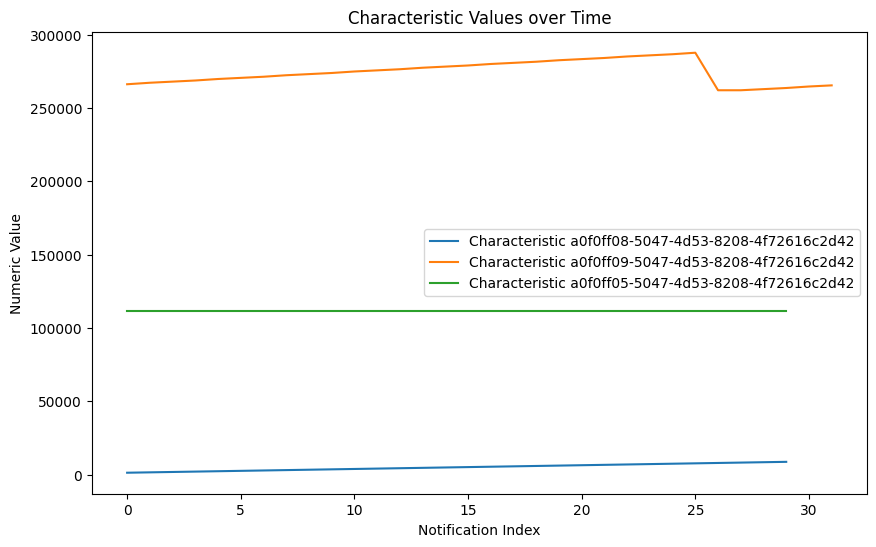

In [17]:
nest_asyncio.apply() # Needed as running asyncio in jupyter notebook

# The notify_characteristics were narrowed down to the following
notify_characteristics = [
    "a0f0ff08-5047-4d53-8208-4f72616c2d42",
    "a0f0ff09-5047-4d53-8208-4f72616c2d42",
    "a0f0ff05-5047-4d53-8208-4f72616c2d42"
]

# Dictionary to store the notifications so can plot them later same as before
notifications = {char: [] for char in notify_characteristics}

# Turns the data into a numeric value same as before
def convert_to_numeric(data):
    return int.from_bytes(data, byteorder='little')

async def notification_handler(sender, data):
    char_uuid = sender.uuid
    numeric_value = convert_to_numeric(data) # Turning the byte data into a numeric value
    print(f"Notification from {char_uuid}: {numeric_value}") 
    notifications[char_uuid].append(numeric_value) # Storing the data for plotting

async def main(address):
    async with BleakClient(address) as client:
        for char_uuid in notify_characteristics:
            await client.start_notify(char_uuid, notification_handler)
        await asyncio.sleep(30)  # Run for 30 seconds
        for char_uuid in notify_characteristics:
            await client.stop_notify(char_uuid)

asyncio.run(main(toothbrush_address))

# print the increments between each notification for each characteristic
# This is used to see if there are any patterns in the data that could relate to time if there is one characteristic that is increasing at a constant rate or being sent at a constant rate
a0f0ff08_increments = [notifications["a0f0ff08-5047-4d53-8208-4f72616c2d42"][i+1] - notifications["a0f0ff08-5047-4d53-8208-4f72616c2d42"][i] for i in range(len(notifications["a0f0ff08-5047-4d53-8208-4f72616c2d42"])-1)]
a0f0ff09_increments = [notifications["a0f0ff09-5047-4d53-8208-4f72616c2d42"][i+1] - notifications["a0f0ff09-5047-4d53-8208-4f72616c2d42"][i] for i in range(len(notifications["a0f0ff09-5047-4d53-8208-4f72616c2d42"])-1)]
a0f0ff05_increments = [notifications["a0f0ff05-5047-4d53-8208-4f72616c2d42"][i+1] - notifications["a0f0ff05-5047-4d53-8208-4f72616c2d42"][i] for i in range(len(notifications["a0f0ff05-5047-4d53-8208-4f72616c2d42"])-1)]
print(f"Increments for a0f0ff08-5047-4d53-8208-4f72616c2d42: {a0f0ff08_increments}")
print(f"Increments for a0f0ff09-5047-4d53-8208-4f72616c2d42: {a0f0ff09_increments}")
print(f"Increments for a0f0ff05-5047-4d53-8208-4f72616c2d42: {a0f0ff05_increments}")

# Plotting the recorded data
plt.figure(figsize=(10, 6))
for char_uuid in notify_characteristics:
    plt.plot(notifications[char_uuid], label=f'Characteristic {char_uuid}')

plt.xlabel('Notification Index')
plt.ylabel('Numeric Value')
plt.title('Characteristic Values over Time')
plt.legend()
plt.show()

Each notification value of a0f0ff08-5047-4d53-8208-4f72616c2d42 is increasing by 256, and we know that that one second is 256 so we deive the value of a0f0ff08-5047-4d53-8208-4f72616c2d42 by 256 to get the time in seconds

In [20]:
last_value = notifications["a0f0ff08-5047-4d53-8208-4f72616c2d42"][-1]
print(f"Last value for a0f0ff08-5047-4d53-8208-4f72616c2d42: {last_value}")

time = last_value / 256
time = time * 1
print(f"Time: {time} seconds")

Last value for a0f0ff08-5047-4d53-8208-4f72616c2d42: 8704
Time: 34.0 seconds


# Proof of concept

Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 1792
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 2048
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 2304
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 2560
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 2816
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 3072
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 3328
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 3584
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 3840
Notification from a0f0ff08-5047-4d53-8208-4f72616c2d42: 4096
Increments for a0f0ff08-5047-4d53-8208-4f72616c2d42: [256, 256, 256, 256, 256, 256, 256, 256, 256]
Last value for a0f0ff08-5047-4d53-8208-4f72616c2d42: 4096
Time: 16.0 seconds


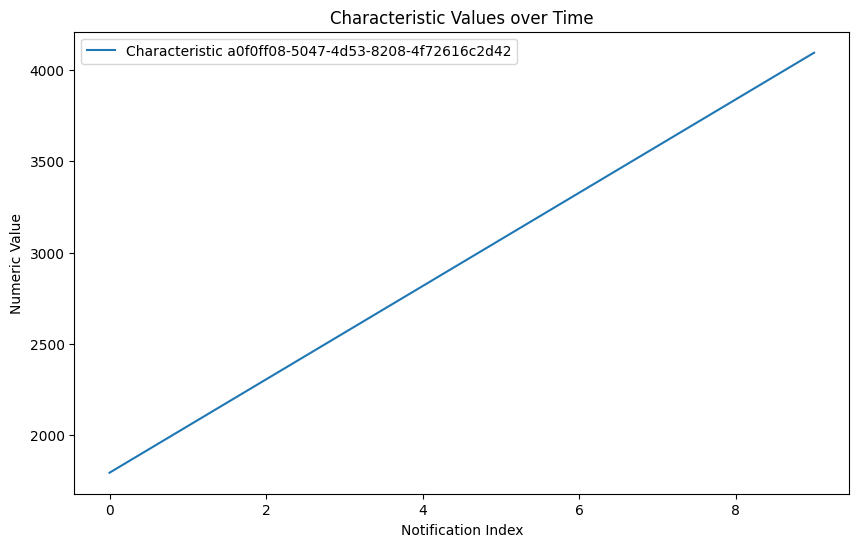

In [25]:
nest_asyncio.apply() # Needed as running asyncio in jupyter notebook

# The notify_characteristics were narrowed down to the following
notify_characteristics = [
    "a0f0ff08-5047-4d53-8208-4f72616c2d42"
]

# Dictionary to store the notifications so can plot them later same as before
notifications = {char: [] for char in notify_characteristics}

# Turns the data into a numeric value same as before
def convert_to_numeric(data):
    return int.from_bytes(data, byteorder='little')

async def notification_handler(sender, data):
    char_uuid = sender.uuid
    numeric_value = convert_to_numeric(data) # Turning the byte data into a numeric value
    print(f"Notification from {char_uuid}: {numeric_value}") 
    notifications[char_uuid].append(numeric_value) # Storing the data for plotting

async def main(address):
    async with BleakClient(address) as client:
        for char_uuid in notify_characteristics:
            await client.start_notify(char_uuid, notification_handler)
        await asyncio.sleep(10)  # Run for 10 seconds to make sure it gets some data
        for char_uuid in notify_characteristics:
            await client.stop_notify(char_uuid)

toothbrush_address = "212B5F11-23E1-ED1E-6CE0-2F09CE4E619C"  # As found in the scan script above
asyncio.run(main(toothbrush_address))

# print the increments between each notification for each characteristic
a0f0ff08_increments = [notifications["a0f0ff08-5047-4d53-8208-4f72616c2d42"][i+1] - notifications["a0f0ff08-5047-4d53-8208-4f72616c2d42"][i] for i in range(len(notifications["a0f0ff08-5047-4d53-8208-4f72616c2d42"])-1)]
print(f"Increments for a0f0ff08-5047-4d53-8208-4f72616c2d42: {a0f0ff08_increments}")

# Getting the last value and converting it to time
last_value = notifications["a0f0ff08-5047-4d53-8208-4f72616c2d42"][-1]
print(f"Last value for a0f0ff08-5047-4d53-8208-4f72616c2d42: {last_value}")
time = last_value / 256 # as this is the increment value
time = time * 1 # as each increment is 1 second
print(f"Time: {time} seconds")


# Plotting the recorded data
plt.figure(figsize=(10, 6))
for char_uuid in notify_characteristics:
    plt.plot(notifications[char_uuid], label=f'Characteristic {char_uuid}')

plt.xlabel('Notification Index')
plt.ylabel('Numeric Value')
plt.title('Characteristic Values over Time')
plt.legend()
plt.show()